* Kaggle比赛情感分析题目：Bag of Words Meets Bags of Popcorn
* Kaggle比赛地址：https://www.kaggle.com/c/word2vec-nlp-tutorial#description

# 数据特征处理

## 一、数据预处理

### 1、加载工具包

In [1]:
import pandas as pd
import numpy as np

### 2、读取并查看数据

In [2]:
root_dir = "data"
# 载入数据集
train = pd.read_csv('%s/%s' % (root_dir, 'labeledTrainData.tsv'), header=0, delimiter="\t", quoting=1)
unlabel_train = pd.read_csv('%s/%s' % (root_dir, 'unlabeledTrainData.tsv'), header=0, delimiter="\t", quoting=3)   
test = pd.read_csv('%s/%s' % (root_dir, 'testData.tsv'), header=0, delimiter="\t", quoting=1)

print(train.shape)
print(train.columns.values)
print(unlabel_train.shape)
print(unlabel_train.columns.values)
print(test.shape)
print(test.columns.values)

print(train.head(3))
print(unlabel_train.head(3))
print(test.head(3))

(25000, 3)
['id' 'sentiment' 'review']
(50000, 2)
['id' 'review']
(25000, 2)
['id' 'review']
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
          id                                             review
0   "9999_0"  "Watching Time Chasers, it obvious that it was...
1  "45057_0"  "I saw this film about 20 years ago and rememb...
2  "15561_0"  "Minor Spoilers<br /><br />In New York, Joan B...
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...


### 3.样本分布（相当的均衡）

In [3]:
train[train.sentiment==1].shape

(12500, 3)

In [4]:
train[train.sentiment==0].shape

(12500, 3)

从原始数据中可以看出：
* 1.labeledTrainData数据用于模型训练；unlabeledTrainData数据用于Word2vec提取特征；testData数据用于提交结果预测。
* 2.文本数据来自网络爬虫数据，带有html格式

### 4.去除HTML标签+数字+全部小写

In [5]:
def review_to_wordlist(review):
    '''
    把IMDB的评论转成词序列
    '''
    from bs4 import BeautifulSoup
    # 1.去掉HTML标签，拿到内容
    review_text = BeautifulSoup(review, "html.parser").get_text()
    
    import re
    # 用正则表达式取出符合规范的部分
    review_text = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 小写化所有的词，并转成词list
    words_list = review_text.lower().split()
    
    #去除停用词。需要下载nltk库，并且下载stopwords。
    from nltk.corpus import stopwords
    stopwords = set(stopwords.words("english"))
    words = [word for word in words_list if word not in stopwords]
    
    # 返回words
    return words

# 预处理数据
label = train['sentiment']
train_data = []
for i in range(len(train['review'])):
    train_data.append(' '.join(review_to_wordlist(train['review'][i])))
    
unlable_data = []    
for i in range(len(unlabel_train['review'])):
    unlable_data.append(' '.join(review_to_wordlist(unlabel_train['review'][i])))   
    
test_data = []
for i in range(len(test['review'])):
    test_data.append(' '.join(review_to_wordlist(test['review'][i])))

# 预览数据
print(train_data[0], '\n')
print(unlable_data[0], '\n')
print(test_data[0])

stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate working

* 查看数据量

In [6]:
print(len(train_data),len(unlable_data),len(test_data))

25000 50000 25000


## 二、特征工程

把文本转换为向量，有几种常见的文本向量处理方法，比如：

* 1.单词计数
* 2.TF-IDF向量
* 3.Word2vec向量

### 1.Count词向量

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
X_test = ['I sed about sed the lack','of any Actually']

count_vec=CountVectorizer(stop_words=None)
print (count_vec.fit_transform(X_test).toarray())
print ('\nvocabulary list:\n\n',count_vec.vocabulary_)

[[1 0 0 1 0 2 1]
 [0 1 1 0 1 0 0]]

vocabulary list:

 {'sed': 5, 'about': 0, 'the': 6, 'lack': 3, 'of': 4, 'any': 2, 'actually': 1}


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(
    max_features=4000,#过滤掉低频
    analyzer='word', # tokenise by character ngrams
    ngram_range=(1,2),  # 二元n-gram模型
    stop_words = 'english')

# 合并训练和测试集以便进行TFIDF向量化操作
data_all = train_data + test_data
len_train = len(train_data)

count_vec.fit(data_all)
data_all = count_vec.transform(data_all)

# 恢复成训练集和测试集部分
count_train_x = data_all[:len_train]
count_test_x = data_all[len_train:]

print('count处理结束.')

print("train: \n", np.shape(count_train_x[0]))
print("test: \n", np.shape(count_test_x[0]))

count处理结束.
train: 
 (1, 4000)
test: 
 (1, 4000)


In [6]:
count_train_x.shape

(25000, 4000)

In [7]:
count_test_x.shape

(25000, 4000)

* Count特征
* count_train_x
* count_test_x

### 2.TF-IDF词向量

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer as TFIDF
"""
min_df: 最小支持度为2（词汇出现的最小次数）
max_features: 默认为None，可设为int，对所有关键词的term frequency进行降序排序，只取前max_features个作为关键词集
strip_accents: 将使用ascii或unicode编码在预处理步骤去除raw document中的重音符号
analyzer: 设置返回类型
token_pattern: 表示token的正则表达式，需要设置analyzer == 'word'，默认的正则表达式选择2个及以上的字母或数字作为token，标点符号默认当作token分隔符，而不会被当作token
ngram_range: 词组切分的长度范围
use_idf: 启用逆文档频率重新加权
use_idf：默认为True，权值是tf*idf，如果设为False，将不使用idf，就是只使用tf，相当于CountVectorizer了。
smooth_idf: idf平滑参数，默认为True，idf=ln((文档总数+1)/(包含该词的文档数+1))+1，如果设为False，idf=ln(文档总数/包含该词的文档数)+1
sublinear_tf: 默认为False，如果设为True，则替换tf为1 + log(tf)
stop_words: 设置停用词，设为english将使用内置的英语停用词，设为一个list可自定义停用词，设为None不使用停用词，设为None且max_df∈[0.7, 1.0)将自动根据当前的语料库建立停用词表
"""
tfidf = TFIDF(min_df=2,
           max_features=4000,#过滤掉低频
           strip_accents='unicode',
           analyzer='word',
           token_pattern=r'\w{1,}',
           ngram_range=(1,2),  # 二元n-gram模型
           use_idf=1,
           smooth_idf=1,
           sublinear_tf=1,
           stop_words = 'english') # 去掉英文停用词

# 合并训练和测试集以便进行TFIDF向量化操作
data_all = train_data + test_data
len_train = len(train_data)

tfidf.fit(data_all)
data_all = tfidf.transform(data_all)
# 恢复成训练集和测试集部分
tfidf_train_x = data_all[:len_train]
tfidf_test_x = data_all[len_train:]
print('TF-IDF处理结束.')

print("train: \n", np.shape(tfidf_train_x[0]))
print("test: \n", np.shape(tfidf_test_x[0]))

TF-IDF处理结束.
train: 
 (1, 4000)
test: 
 (1, 4000)


In [9]:
tfidf_train_x.shape

(25000, 4000)

In [10]:
tfidf_test_x.shape

(25000, 4000)

### 3.Word2vec词向量

* gensim.models.word2vec.Word2Vec 输入数据是字符的list格式，所以需要对数据进行预处理

#### 3.1 输入数据预处理

In [5]:
#预处理训练数据
train_words = []
for i in train_data:
    train_words.append(i.split())
    
#预处理特征数据
unlable_words = []
for i in unlable_data:
    unlable_words.append(i.split())

#预处理测试数据
test_words = []
for i in test_data:
    test_words.append(i.split())

#合并数据
all_words = train_words + unlable_words + test_words

len(all_words)

100000

#### 3.2数据预览

In [6]:
# 预览数据
print(all_words[0])

['stuff', 'going', 'moment', 'mj', 'started', 'listening', 'music', 'watching', 'odd', 'documentary', 'watched', 'wiz', 'watched', 'moonwalker', 'maybe', 'want', 'get', 'certain', 'insight', 'guy', 'thought', 'really', 'cool', 'eighties', 'maybe', 'make', 'mind', 'whether', 'guilty', 'innocent', 'moonwalker', 'part', 'biography', 'part', 'feature', 'film', 'remember', 'going', 'see', 'cinema', 'originally', 'released', 'subtle', 'messages', 'mj', 'feeling', 'towards', 'press', 'also', 'obvious', 'message', 'drugs', 'bad', 'kay', 'visually', 'impressive', 'course', 'michael', 'jackson', 'unless', 'remotely', 'like', 'mj', 'anyway', 'going', 'hate', 'find', 'boring', 'may', 'call', 'mj', 'egotist', 'consenting', 'making', 'movie', 'mj', 'fans', 'would', 'say', 'made', 'fans', 'true', 'really', 'nice', 'actual', 'feature', 'film', 'bit', 'finally', 'starts', 'minutes', 'excluding', 'smooth', 'criminal', 'sequence', 'joe', 'pesci', 'convincing', 'psychopathic', 'powerful', 'drug', 'lord', 

#### 3.3 Word2vec模型训练保存

In [7]:
from gensim.models.word2vec import Word2Vec
import os

# 设定词向量训练的参数
size = 100      # Word vector dimensionality
min_count = 3   # Minimum word count
num_workers = 4 # Number of threads to run in parallel
window = 10     # Context window size
model_name = '{}size_{}min_count_{}window.model'.format(size, min_count, window)

wv_model = Word2Vec(all_words, workers=num_workers, size=size, min_count = min_count,window = window)
wv_model.init_sims(replace=True)#模型训练好后，锁定模型

wv_model.save(model_name)#保存模型

C:\Users\xuliang\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#### 3.4 Word2vec模型加载

In [8]:
from gensim.models.word2vec import Word2Vec
wv_model = Word2Vec.load("100size_3min_count_10window.model")

#### 3.5 word2vec特征处理

此处画风比较奇特:
* 将一个句子对应的词向量求和取平均，做为机器学习的特征，但是效果还不错。

In [40]:
def to_review_vector(review):
    global word_vec
    word_vec = np.zeros((1,100))
    for word in review:
        if word in wv_model:
            word_vec += np.array([wv_model[word]])
    return pd.Series(word_vec.mean(axis = 0))

train_data_features = []

for i in train_words:
    train_data_features.append(to_review_vector(i))

test_data_features = []
for i in test_words:
    test_data_features.append(to_review_vector(i))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


# 机器学习方法

## 一、机器学习建模

### 1. TF-IDF+朴素贝叶斯模型+交叉验证

In [25]:
# 朴素贝叶斯训练
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.naive_bayes import MultinomialNB as MNB

model_MNB = MNB() # (alpha=1.0, class_prior=None, fit_prior=True)
# 为了在预测的时候使用
model_MNB.fit(tfidf_train_x, label)

print("多项式贝叶斯分类器5折交叉验证得分: ", cross_val_score(model_MNB, tfidf_train_x, label, cv=5, scoring='roc_auc'))
print("多项式贝叶斯分类器5折交叉验证得分: ", np.mean(cross_val_score(model_MNB, tfidf_train_x, label, cv=5, scoring='roc_auc')))


test_predicted = np.array(model_MNB.predict(tfidf_test_x))

print('保存结果...')

submission_df = pd.DataFrame({'id': test['id'].values, 'sentiment': test_predicted})
print(submission_df.head())
submission_df.to_csv('submission_mnb_tfidf.csv', index = False)

print('结束.')

多项式贝叶斯分类器5折交叉验证得分:  [0.92969136 0.93232992 0.93167488 0.93575024 0.92634304]
多项式贝叶斯分类器5折交叉验证得分:  0.9311578880000001
保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          1
3    7186_2          1
4   12128_7          1
结束.


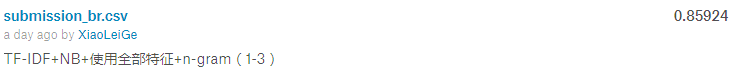

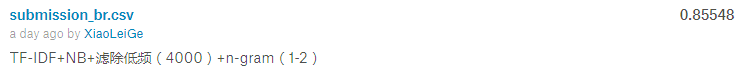

### 2. TF-IDF+逻辑回归模型+网格搜索交叉验证

In [26]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import GridSearchCV

# 设定grid search的参数
grid_values = {'C': [0.1, 1, 10]}  
# 设定打分为roc_auc
"""
penalty: l1 or l2, 用于指定惩罚中使用的标准。
"""
model_LR = GridSearchCV(LR(penalty='l2', dual=True, random_state=0), grid_values, scoring='roc_auc', cv=5)
model_LR.fit(tfidf_train_x, label)

# 输出结果
print("最好的参数：")
print( model_LR.best_params_)

print("最好的得分：")
print(model_LR.best_score_)


print("网格搜索参数及得分：")
print(model_LR.grid_scores_)

print("网格搜索结果：")
print(model_LR.cv_results_)

model_LR = LR(penalty='l2', dual=True, random_state=0)
model_LR.fit(tfidf_train_x, label)

test_predicted = np.array(model_LR.predict(tfidf_test_x))

print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_lr_tfidf.csv',columns = ['id','sentiment'], index = False)
print('结束.')

最好的参数：
{'C': 1}
最好的得分：
0.9507756479999999
网格搜索参数及得分：
[mean: 0.93949, std: 0.00324, params: {'C': 0.1}, mean: 0.95078, std: 0.00276, params: {'C': 1}, mean: 0.94398, std: 0.00275, params: {'C': 10}]
网格搜索结果：
{'mean_fit_time': array([0.12460012, 0.17419996, 0.4506001 ]), 'std_fit_time': array([0.01323034, 0.02166458, 0.01783922]), 'mean_score_time': array([0.0026    , 0.00319996, 0.00260005]), 'std_score_time': array([0.00048982, 0.00040011, 0.00048996]), 'param_C': masked_array(data=[0.1, 1, 10],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.1}, {'C': 1}, {'C': 10}], 'split0_test_score': array([0.93795456, 0.95020352, 0.9436768 ]), 'split1_test_score': array([0.94196192, 0.9542512 , 0.94876688]), 'split2_test_score': array([0.93759728, 0.9471152 , 0.9402704 ]), 'split3_test_score': array([0.9444336 , 0.95359056, 0.94413712]), 'split4_test_score': array([0.93548752, 0.94871776, 0.94303536]), 'mean_test_score': array([0.939486

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


结束.


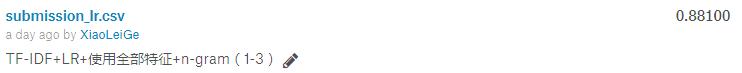

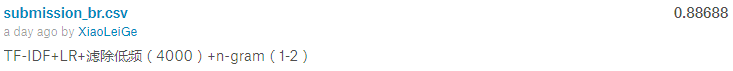

### 3. TF-IDF+SVM模型+网格搜索交叉验证

* SVM模型训练太耗时，尤其是使用网格搜索训练
* 参数调优时，使用param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}+5折交叉验证，连续训练时长将近48小时。

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

'''
线性的SVM只需要，只需要调优正则化参数C
基于RBF核的SVM，需要调优gamma参数和C
'''
param_grid = {'C': [10],'gamma': [1]}

model_SVM = GridSearchCV(SVC(), param_grid, scoring='roc_auc', cv=5)
model_SVM.fit(tfidf_train_x, label)

# 输出结果
print("最好的参数：")
print( model_SVM.best_params_)

print("最好的得分：")
print(model_SVM.best_score_)

print("网格搜索参数及得分：")
print(model_SVM.grid_scores_)


最好的参数：
{'C': 10, 'gamma': 1}
最好的得分：
0.9517343039999999
网格搜索参数及得分：
[mean: 0.95173, std: 0.00264, params: {'C': 10, 'gamma': 1}]


In [20]:
from sklearn.externals import joblib
joblib.dump(model_SVM, "model_SVM")
model_SVM = joblib.load("model_SVM")

In [21]:
from sklearn.svm import SVC
svm = SVC(kernel='linear',C=10,gamma = 1)
svm.fit(tfidf_train_x, label)

test_predicted = np.array(svm.predict(tfidf_test_x))
print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_svm_tfidf.csv',columns = ['id','sentiment'], index = False)
print('结束.')

保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          0
3    7186_2          0
4   12128_7          1
结束.


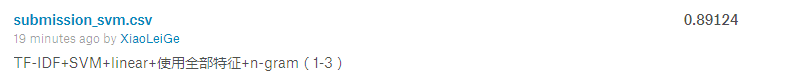

### 4. TF-IDF+MLP（多层感知机模型）

In [15]:
#None 维度在这里是一个 batch size 的占位符

import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

#train test split
mlp_train_x, mlp_test_x, mlp_train_y, mlp_test_y = train_test_split(tfidf_train_x, label, test_size=0.3, random_state=123)

model_MLP = Sequential()
#model.add(Dense(3, activation='relu', input_shape=(18,)))

model_MLP.add(Dense(10, input_shape=(4000,), activation='relu'))#

model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(2, activation='softmax'))

model_MLP.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_MLP.summary()

keras_y_train = np.array(keras.utils.to_categorical(mlp_train_y, 2))
keras_y_test = np.array(keras.utils.to_categorical(mlp_test_y, 2))

#仅保存最好的模型
filepath="model_MLP/weights.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,mode='max')#验证集准确率比之前效果好就保存权重

callbacks_list = [checkpoint]

model_MLP.fit(mlp_train_x, keras_y_train, validation_data=(mlp_test_x, keras_y_test), epochs=500, batch_size=5000,callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 10)                40010     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 22        
Total params: 40,032
Trainable params: 40,032
Non-trainable params: 0
_________________________________________________________________
Train on 17500 samples, validate on 7500 samples
Epoch 1/500
17500/17500 [==============================] - 1s 61us/step - loss: 0.6908 - acc: 0.5581 - val_loss: 0.6856 - val_acc: 0.6764

Epoch 00001: val_acc improved from -inf to 0.67640, saving model to model_MLP/weights.best.hdf5
Epoch 2/500
17500/17500 [==============================] - 1s 42us/step - loss: 0.6817 - acc: 0.6987 - val_loss: 0.674

17500/17500 [==============================] - 1s 42us/step - loss: 0.2633 - acc: 0.9078 - val_loss: 0.3091 - val_acc: 0.8743

Epoch 00068: val_acc improved from 0.87400 to 0.87427, saving model to model_MLP/weights.best.hdf5
Epoch 69/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.2610 - acc: 0.9079 - val_loss: 0.3083 - val_acc: 0.8736

Epoch 00069: val_acc did not improve from 0.87427
Epoch 70/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.2589 - acc: 0.9078 - val_loss: 0.3075 - val_acc: 0.8741

Epoch 00070: val_acc did not improve from 0.87427
Epoch 71/500
17500/17500 [==============================] - 1s 42us/step - loss: 0.2557 - acc: 0.9075 - val_loss: 0.3067 - val_acc: 0.8736

Epoch 00071: val_acc did not improve from 0.87427
Epoch 72/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.2549 - acc: 0.9093 - val_loss: 0.3059 - val_acc: 0.8739

Epoch 00072: val_acc did not improve from 0.87427
Epoch 73/500
1

17500/17500 [==============================] - 1s 41us/step - loss: 0.2094 - acc: 0.9256 - val_loss: 0.2979 - val_acc: 0.8735

Epoch 00110: val_acc did not improve from 0.87467
Epoch 111/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.2078 - acc: 0.9255 - val_loss: 0.2980 - val_acc: 0.8735

Epoch 00111: val_acc did not improve from 0.87467
Epoch 112/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.2054 - acc: 0.9269 - val_loss: 0.2981 - val_acc: 0.8735

Epoch 00112: val_acc did not improve from 0.87467
Epoch 113/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.2042 - acc: 0.9279 - val_loss: 0.2983 - val_acc: 0.8732

Epoch 00113: val_acc did not improve from 0.87467
Epoch 114/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.2053 - acc: 0.9266 - val_loss: 0.2984 - val_acc: 0.8735

Epoch 00114: val_acc did not improve from 0.87467
Epoch 115/500
17500/17500 [==============================] 

17500/17500 [==============================] - 1s 41us/step - loss: 0.1766 - acc: 0.9366 - val_loss: 0.3106 - val_acc: 0.8693

Epoch 00153: val_acc did not improve from 0.87467
Epoch 154/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.1768 - acc: 0.9385 - val_loss: 0.3109 - val_acc: 0.8691

Epoch 00154: val_acc did not improve from 0.87467
Epoch 155/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.1743 - acc: 0.9376 - val_loss: 0.3114 - val_acc: 0.8692

Epoch 00155: val_acc did not improve from 0.87467
Epoch 156/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.1742 - acc: 0.9410 - val_loss: 0.3118 - val_acc: 0.8692

Epoch 00156: val_acc did not improve from 0.87467
Epoch 157/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.1729 - acc: 0.9406 - val_loss: 0.3122 - val_acc: 0.8687

Epoch 00157: val_acc did not improve from 0.87467
Epoch 158/500
17500/17500 [==============================] 

17500/17500 [==============================] - 1s 41us/step - loss: 0.1528 - acc: 0.9471 - val_loss: 0.3323 - val_acc: 0.8645

Epoch 00196: val_acc did not improve from 0.87467
Epoch 197/500
17500/17500 [==============================] - 1s 43us/step - loss: 0.1519 - acc: 0.9484 - val_loss: 0.3328 - val_acc: 0.8640

Epoch 00197: val_acc did not improve from 0.87467
Epoch 198/500
17500/17500 [==============================] - 1s 44us/step - loss: 0.1530 - acc: 0.9458 - val_loss: 0.3334 - val_acc: 0.8639

Epoch 00198: val_acc did not improve from 0.87467
Epoch 199/500
17500/17500 [==============================] - 1s 45us/step - loss: 0.1519 - acc: 0.9485 - val_loss: 0.3340 - val_acc: 0.8636

Epoch 00199: val_acc did not improve from 0.87467
Epoch 200/500
17500/17500 [==============================] - 1s 47us/step - loss: 0.1518 - acc: 0.9472 - val_loss: 0.3346 - val_acc: 0.8640

Epoch 00200: val_acc did not improve from 0.87467
Epoch 201/500
17500/17500 [==============================] 

17500/17500 [==============================] - 1s 41us/step - loss: 0.1356 - acc: 0.9530 - val_loss: 0.3580 - val_acc: 0.8584

Epoch 00239: val_acc did not improve from 0.87467
Epoch 240/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.1352 - acc: 0.9530 - val_loss: 0.3587 - val_acc: 0.8583

Epoch 00240: val_acc did not improve from 0.87467
Epoch 241/500
17500/17500 [==============================] - 1s 42us/step - loss: 0.1358 - acc: 0.9533 - val_loss: 0.3594 - val_acc: 0.8579

Epoch 00241: val_acc did not improve from 0.87467
Epoch 242/500
17500/17500 [==============================] - 1s 45us/step - loss: 0.1356 - acc: 0.9531 - val_loss: 0.3599 - val_acc: 0.8581

Epoch 00242: val_acc did not improve from 0.87467
Epoch 243/500
17500/17500 [==============================] - 1s 44us/step - loss: 0.1334 - acc: 0.9538 - val_loss: 0.3606 - val_acc: 0.8579

Epoch 00243: val_acc did not improve from 0.87467
Epoch 244/500
17500/17500 [==============================] 

17500/17500 [==============================] - 1s 41us/step - loss: 0.1230 - acc: 0.9581 - val_loss: 0.3863 - val_acc: 0.8539

Epoch 00282: val_acc did not improve from 0.87467
Epoch 283/500
17500/17500 [==============================] - 1s 53us/step - loss: 0.1230 - acc: 0.9569 - val_loss: 0.3869 - val_acc: 0.8540

Epoch 00283: val_acc did not improve from 0.87467
Epoch 284/500
17500/17500 [==============================] - 1s 51us/step - loss: 0.1223 - acc: 0.9561 - val_loss: 0.3875 - val_acc: 0.8545

Epoch 00284: val_acc did not improve from 0.87467
Epoch 285/500
17500/17500 [==============================] - 1s 58us/step - loss: 0.1206 - acc: 0.9579 - val_loss: 0.3882 - val_acc: 0.8543

Epoch 00285: val_acc did not improve from 0.87467
Epoch 286/500
17500/17500 [==============================] - 1s 54us/step - loss: 0.1211 - acc: 0.9587 - val_loss: 0.3889 - val_acc: 0.8536

Epoch 00286: val_acc did not improve from 0.87467
Epoch 287/500
17500/17500 [==============================] 

17500/17500 [==============================] - 1s 42us/step - loss: 0.1091 - acc: 0.9626 - val_loss: 0.4171 - val_acc: 0.8527

Epoch 00325: val_acc did not improve from 0.87467
Epoch 326/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.1103 - acc: 0.9637 - val_loss: 0.4180 - val_acc: 0.8523

Epoch 00326: val_acc did not improve from 0.87467
Epoch 327/500
17500/17500 [==============================] - 1s 40us/step - loss: 0.1108 - acc: 0.9622 - val_loss: 0.4186 - val_acc: 0.8520

Epoch 00327: val_acc did not improve from 0.87467
Epoch 328/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.1092 - acc: 0.9626 - val_loss: 0.4191 - val_acc: 0.8520

Epoch 00328: val_acc did not improve from 0.87467
Epoch 329/500
17500/17500 [==============================] - 1s 40us/step - loss: 0.1085 - acc: 0.9634 - val_loss: 0.4198 - val_acc: 0.8520

Epoch 00329: val_acc did not improve from 0.87467
Epoch 330/500
17500/17500 [==============================] 

17500/17500 [==============================] - 1s 41us/step - loss: 0.1004 - acc: 0.9670 - val_loss: 0.4484 - val_acc: 0.8517

Epoch 00368: val_acc did not improve from 0.87467
Epoch 369/500
17500/17500 [==============================] - 1s 40us/step - loss: 0.0998 - acc: 0.9672 - val_loss: 0.4489 - val_acc: 0.8512

Epoch 00369: val_acc did not improve from 0.87467
Epoch 370/500
17500/17500 [==============================] - 1s 40us/step - loss: 0.0972 - acc: 0.9683 - val_loss: 0.4495 - val_acc: 0.8504

Epoch 00370: val_acc did not improve from 0.87467
Epoch 371/500
17500/17500 [==============================] - 1s 40us/step - loss: 0.0973 - acc: 0.9677 - val_loss: 0.4502 - val_acc: 0.8504

Epoch 00371: val_acc did not improve from 0.87467
Epoch 372/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.0971 - acc: 0.9679 - val_loss: 0.4513 - val_acc: 0.8509

Epoch 00372: val_acc did not improve from 0.87467
Epoch 373/500
17500/17500 [==============================] 

17500/17500 [==============================] - 1s 41us/step - loss: 0.0893 - acc: 0.9715 - val_loss: 0.4807 - val_acc: 0.8493

Epoch 00411: val_acc did not improve from 0.87467
Epoch 412/500
17500/17500 [==============================] - 1s 40us/step - loss: 0.0890 - acc: 0.9725 - val_loss: 0.4817 - val_acc: 0.8493

Epoch 00412: val_acc did not improve from 0.87467
Epoch 413/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.0885 - acc: 0.9730 - val_loss: 0.4826 - val_acc: 0.8491

Epoch 00413: val_acc did not improve from 0.87467
Epoch 414/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.0884 - acc: 0.9729 - val_loss: 0.4831 - val_acc: 0.8491

Epoch 00414: val_acc did not improve from 0.87467
Epoch 415/500
17500/17500 [==============================] - 1s 40us/step - loss: 0.0890 - acc: 0.9722 - val_loss: 0.4838 - val_acc: 0.8491

Epoch 00415: val_acc did not improve from 0.87467
Epoch 416/500
17500/17500 [==============================] 

17500/17500 [==============================] - 1s 41us/step - loss: 0.0816 - acc: 0.9754 - val_loss: 0.5133 - val_acc: 0.8481

Epoch 00454: val_acc did not improve from 0.87467
Epoch 455/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.0801 - acc: 0.9758 - val_loss: 0.5141 - val_acc: 0.8484

Epoch 00455: val_acc did not improve from 0.87467
Epoch 456/500
17500/17500 [==============================] - 1s 40us/step - loss: 0.0789 - acc: 0.9767 - val_loss: 0.5153 - val_acc: 0.8484

Epoch 00456: val_acc did not improve from 0.87467
Epoch 457/500
17500/17500 [==============================] - 1s 40us/step - loss: 0.0796 - acc: 0.9766 - val_loss: 0.5164 - val_acc: 0.8484

Epoch 00457: val_acc did not improve from 0.87467
Epoch 458/500
17500/17500 [==============================] - 1s 40us/step - loss: 0.0791 - acc: 0.9774 - val_loss: 0.5171 - val_acc: 0.8483

Epoch 00458: val_acc did not improve from 0.87467
Epoch 459/500
17500/17500 [==============================] 

17500/17500 [==============================] - 1s 41us/step - loss: 0.0724 - acc: 0.9802 - val_loss: 0.5484 - val_acc: 0.8479

Epoch 00497: val_acc did not improve from 0.87467
Epoch 498/500
17500/17500 [==============================] - 1s 41us/step - loss: 0.0713 - acc: 0.9809 - val_loss: 0.5495 - val_acc: 0.8479

Epoch 00498: val_acc did not improve from 0.87467
Epoch 499/500
17500/17500 [==============================] - 1s 40us/step - loss: 0.0721 - acc: 0.9797 - val_loss: 0.5502 - val_acc: 0.8480

Epoch 00499: val_acc did not improve from 0.87467
Epoch 500/500
17500/17500 [==============================] - 1s 40us/step - loss: 0.0710 - acc: 0.9811 - val_loss: 0.5509 - val_acc: 0.8480

Epoch 00500: val_acc did not improve from 0.87467


In [16]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, Embedding
from keras.models import Sequential
from keras.utils import plot_model

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import gensim
from gensim.models.word2vec import Word2Vec
from keras.callbacks import ModelCheckpoint


model_MLP = Sequential()

model_MLP.add(Dense(10, input_shape=(4000,), activation='relu'))#

model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(2, activation='softmax'))

model_MLP.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_MLP.summary()

# load weights
model_MLP.load_weights("model_MLP/weights.best.hdf5")


C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 10)                40010     
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 22        
Total params: 40,032
Trainable params: 40,032
Non-trainable params: 0
_________________________________________________________________


In [17]:
test_predicted = np.array(model_MLP.predict_classes(tfidf_test_x))
print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_mlp_tfidf.csv',columns = ['id','sentiment'], index = False)
print('结束.')

保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          0
3    7186_2          1
4   12128_7          1
结束.


### 5. TF-IDF+DT

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

model_DT = DecisionTreeClassifier()
model_DT.fit(tfidf_train_x, label)

scores = cross_val_score(model_DT, tfidf_train_x, label, cv=5, scoring='roc_auc')

print("决策树 5折交叉验证得分: ", scores)
print("决策树 5折交叉验证平均得分: ", np.mean(scores))

test_predicted = np.array(model_DT.predict(tfidf_test_x))

print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_dt_tfidf.csv',columns = ['id','sentiment'], index = False)
print('结束.')

决策树 5折交叉验证得分: 
 [0.7128 0.705  0.7102 0.7062 0.7096]
决策树 5折交叉验证平均得分: 
 0.7087600000000001
保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          1
3    7186_2          1
4   12128_7          1
结束.


### 6. TF-IDF+xgboost

In [21]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

model_XGB = XGBClassifier(n_estimators=150, min_samples_leaf=3, max_depth=6)
"""
AttributeError: 'list' object has no attribute 'shape'
list => np.array
"""
model_XGB.fit(tfidf_train_x, label)

scores = cross_val_score(model_XGB, tfidf_train_x, label, cv=5, scoring='roc_auc')

print("XGB 5折交叉验证得分: ", scores)
print("XGB 5折交叉验证平均得分: ", np.mean(scores))

test_predicted = np.array(model_XGB.predict(tfidf_test_x))

print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_xgb_tfidf.csv',columns = ['id','sentiment'], index = False)
print('结束.')

XGB 5折交叉验证得分:  [0.91607008 0.91845504 0.91138704 0.922242   0.9142976 ]
XGB 5折交叉验证平均得分:  0.916490352
保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          1
3    7186_2          1
4   12128_7          1
结束.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 7. TF-IDF+GBDT

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

model_GBDT = GradientBoostingClassifier()
model_GBDT.fit(tfidf_train_x, label)

scores = cross_val_score(model_GBDT, tfidf_train_x, label, cv=5, scoring='roc_auc')

print("GBDT 5折交叉验证得分: \n", scores)
print("GBDT 折交叉验证平均得分: \n", np.mean(scores))

test_predicted = np.array(model_GBDT.predict(tfidf_test_x))

print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_gbdt_tfidf.csv',columns = ['id','sentiment'], index = False)
print('结束.')

GBDT 5折交叉验证得分: 
 [0.88863632 0.88981456 0.88274104 0.89644848 0.88723104]
GBDT 折交叉验证平均得分: 
 0.888974288
保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          1
3    7186_2          1
4   12128_7          1
结束.


### 8. TF-IDF+RF

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=0)
model_RF.fit(tfidf_train_x, label)

scores = cross_val_score(model_RF, tfidf_train_x, label, cv=5, scoring='roc_auc')

print("随机森林 5折交叉验证得分: ", scores)
print("随机森林 5折交叉验证平均得分: ", np.mean(scores))

test_predicted = np.array(model_RF.predict(tfidf_test_x))

print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_rfc_tfidf.csv',columns = ['id','sentiment'], index = False)
print('结束.')

随机森林 5折交叉验证得分:  [0.89770248 0.90205984 0.89408512 0.9035528  0.89733304]
随机森林 5折交叉验证平均得分:  0.898946656
保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          1
3    7186_2          1
4   12128_7          1
结束.


### 9. TF-IDF+Voting

In [27]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

model_VOT = VotingClassifier(estimators=[('lr', model_LR), ('xgb', model_XGB), ('rf', model_RF)],voting='hard')
model_VOT.fit(tfidf_train_x, np.array(label))

scores = cross_val_score(model_VOT, tfidf_train_x,label, cv=5, scoring=None,n_jobs = -1)

print("VotingClassifier 5折交叉验证得分: \n", scores)
print("VotingClassifier 5折交叉验证平均得分: \n", np.mean(scores))

test_predicted = np.array(model_VOT.predict(tfidf_test_x))

print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_vot_tfidf.csv',columns = ['id','sentiment'], index = False)
print('结束.')

VotingClassifier 5折交叉验证得分: 
 [0.8394 0.8568 0.8388 0.854  0.8464]
VotingClassifier 5折交叉验证平均得分: 
 0.84708


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          1
3    7186_2          1
4   12128_7          1
结束.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 10. TF-IDF+Stacking

In [35]:
'''模型融合中使用到的各个单模型'''
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
#from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

# 划分train数据集,调用代码,把数据集名字转成和代码一样
X = tfidf_train_x
y = np.array(label)

X_test_features = tfidf_test_x

stacking_LR = LR(penalty='l2', dual=True, random_state=0)

stacking_xgb = XGBClassifier(n_estimators=150, min_samples_leaf=3, max_depth=6)

stacking_rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=0)


clfs = [stacking_LR,stacking_xgb,stacking_rf]#模型

# 创建n_folds
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=1)#K-Flod数据

# 创建零矩阵（存储第一层的预测结果）
dataset_blend_train = np.zeros((X.shape[0], len(clfs)))#行数：训练集的行数，列数：模型的个数

dataset_blend_test = np.zeros((X_test_features.shape[0], len(clfs)))#行数：测试集数量，列数：模型的个数
dataset_blend_test_j = np.zeros((X_test_features.shape[0], n_folds))#行数：测试集数量，列数：K折

# 建立第一层模型
for j, clf in enumerate(clfs):#枚举分类器
    i = 0
    for train_index, test_index in skf.split(X, y):#K折数据
        X_1_train, y_1_train, X_1_test, y_1_test = X[train_index], y[train_index], X[test_index], y[test_index]
        
        clf.fit(X_1_train, y_1_train)#第j个模型预测第k折数据
        
        y_submission = clf.predict_proba(X_1_test)[:, 1]#第j个模型预测剩下的1折数据，去除答案是1的概率列
        
        dataset_blend_train[test_index, j] = y_submission#第j个模型预测的第k折数据的答案写到预测结果里
        
        dataset_blend_test_j[:, i] = clf.predict_proba(X_test_features)[:, 1]#对测试集进行预测
        
        i = i + 1 #第i折
        
    '''对于测试集，直接用这k个模型的预测值均值作为新的特征。'''
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1) #每个模型的K折的预测值取平均做为第j个分类器的预测值
    
# 用建立第二层模型

C = [0.01,0.1,1,10]

for i in C:
    stacking_model_lr = LR(C=i, max_iter=100)
    print(i)
    aucs = []
    for train_index, test_index in skf.split(dataset_blend_train, y):#K折数据
        X_2_train, y_2_train, X_2_test, y_2_test = dataset_blend_train[train_index], y[train_index], dataset_blend_train[test_index], y[test_index]
        stacking_model_lr.fit(X_2_train, y_2_train)
        test_predict_proba = stacking_model_lr.predict_proba(X_2_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_2_test, test_predict_proba, pos_label=1)
        print("stacking auc",auc(fpr, tpr))
        aucs.append(auc(fpr, tpr))
    print(np.average(aucs))

    stacking_model_lr = LR(C=10, max_iter=100)

stacking_model_lr.fit(dataset_blend_train, y)

test_predict = stacking_model_lr.predict(dataset_blend_test)

test_predicted = np.array(test_predict)

print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_stacking_tfidf.csv',columns = ['id','sentiment'], index = False)
print('结束.')

0.01
stacking auc 0.9520484800000001
stacking auc 0.94503472
stacking auc 0.94511664
stacking auc 0.9553464
stacking auc 0.94973888
0.949457024
0.1
stacking auc 0.95298912
stacking auc 0.9471843200000001
stacking auc 0.9471433599999999
stacking auc 0.9565649600000001
stacking auc 0.9505606400000002
0.95088848
1
stacking auc 0.9529368000000001
stacking auc 0.9477648
stacking auc 0.94768992
stacking auc 0.9566342399999999
stacking auc 0.95043744
0.9510926399999999
10
stacking auc 0.9528793600000001
stacking auc 0.9478297600000001
stacking auc 0.94773648
stacking auc 0.9566390399999998
stacking auc 0.9503939199999999
0.9510957120000001
保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          1
3    7186_2          1
4   12128_7          1
结束.


## 二、Word2vec+机器学习建模

### 1.Word2vec+LR

In [41]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import cross_val_score

wv_model_LR = LR(penalty='l2', dual=True, random_state=0)
wv_model_LR.fit(train_data_features, label)

scores = cross_val_score(wv_model_LR, train_data_features, label, cv=10, scoring='roc_auc')

print("LR分类器 10折交叉验证得分: \n", scores)
print("LR分类器 10折交叉验证平均得分: \n", np.mean(scores))

test_predicted = np.array(wv_model_LR.predict(test_data_features))
print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_lr_wv.csv',columns = ['id','sentiment'], index = False)
print('结束.')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


LR分类器 10折交叉验证得分: 
 [0.9412576  0.93986304 0.94739904 0.93963392 0.93683136 0.93972416
 0.94117184 0.94543232 0.93660928 0.94397184]
LR分类器 10折交叉验证平均得分: 
 0.9411894399999999
保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          1
3    7186_2          0
4   12128_7          1
结束.


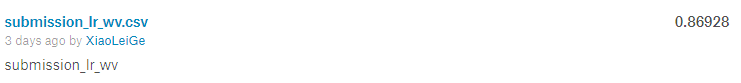

### 2.Word2vec+GNB

In [42]:
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.cross_validation import cross_val_score

wv_gnb_model = GNB()
wv_gnb_model.fit(train_data_features, label)


scores = cross_val_score(wv_gnb_model, train_data_features, label, cv=10, scoring='roc_auc')
print("\n高斯贝叶斯分类器 10折交叉验证得分: \n", scores)
print("\n高斯贝叶斯分类器 10折交叉验证平均得分: \n", np.mean(scores))

test_predicted = np.array(wv_gnb_model.predict(test_data_features))
print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_gnb_wv.csv',columns = ['id','sentiment'], index = False)
print('结束.')


高斯贝叶斯分类器 10折交叉验证得分: 
 [0.80043648 0.78343712 0.78856768 0.79913536 0.7964928  0.78470464
 0.79811424 0.80671424 0.7928432  0.80504768]

高斯贝叶斯分类器 10折交叉验证平均得分: 
 0.7955493440000001
保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          0
3    7186_2          0
4   12128_7          0
结束.


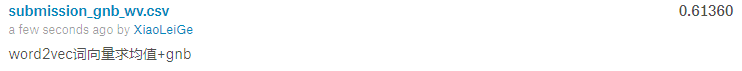

### 3.Word2vec+Knn

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

wv_knn_model = KNeighborsClassifier(n_neighbors=5)
wv_knn_model.fit(train_data_features, label)

scores = cross_val_score(wv_knn_model, train_data_features, label, cv=10, scoring='roc_auc')

print("\nknn算法 10折交叉验证得分: \n", scores)
print("\nknn算法 10折交叉验证平均得分: \n", np.mean(scores))

test_predicted = np.array(wv_knn_model.predict(test_data_features))
print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_knn_wv.csv',columns = ['id','sentiment'], index = False)
print('结束.')


knn算法 10折交叉验证得分: 
 [0.89709856 0.89423168 0.90665152 0.8890768  0.89263712 0.89179264
 0.88568    0.90213216 0.89707968 0.88941376]

knn算法 10折交叉验证平均得分: 
 0.894579392


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          0
3    7186_2          0
4   12128_7          1
结束.


### 4.Word2vec+SVM

In [60]:
from sklearn.svm import SVC

'''
线性的SVM只需要，只需要调优正则化参数C
基于RBF核的SVM，需要调优gamma参数和C
'''

wv_svm_model = SVC(kernel='linear',C=10,gamma = 1)
wv_svm_model.fit(train_data_features, label)


最好的参数：


AttributeError: 'SVC' object has no attribute 'best_params_'

In [61]:
test_predicted = np.array(wv_svm_model.predict(test_data_features))
print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_svm_wv.csv',columns = ['id','sentiment'], index = False)
print('结束.')

保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          1
3    7186_2          0
4   12128_7          1
结束.


### 5.Word2vec+DT

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

wv_tree_model = DecisionTreeClassifier()
wv_tree_model.fit(train_data_features, label)

scores = cross_val_score(wv_tree_model, train_data_features, label, cv=5, scoring='roc_auc')

print("决策树 10折交叉验证得分: \n", scores)
print("决策树 10折交叉验证平均得分: \n", np.mean(scores))

test_predicted = np.array(wv_tree_model.predict(test_data_features))

print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_dtc_wv.csv',columns = ['id','sentiment'], index = False)
print('结束.')


决策树 10折交叉验证得分: 
 [0.7498 0.7506 0.7572 0.7648 0.736 ]

决策树 10折交叉验证平均得分: 
 0.75168


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          0
3    7186_2          0
4   12128_7          1
结束.


### 6.Word2vec+xgboost

In [43]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

wv_xgb_model = XGBClassifier(n_estimators=150, min_samples_leaf=3, max_depth=6)
"""
AttributeError: 'list' object has no attribute 'shape'
list => np.array
"""
wv_xgb_model.fit(pd.DataFrame(train_data_features), label)

scores = cross_val_score(wv_xgb_model, pd.DataFrame(train_data_features), label, cv=5, scoring='roc_auc')

print("XGB 5折交叉验证得分: \n", scores)
print("XGB 5折交叉验证平均得分: \n", np.mean(scores))

test_predicted = np.array(wv_xgb_model.predict(pd.DataFrame(test_data_features)))

print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_xgb_wv.csv',columns = ['id','sentiment'], index = False)
print('结束.')

XGB 5折交叉验证得分: 
 [0.94458    0.94526208 0.94390896 0.9463752  0.94129232]
XGB 5折交叉验证平均得分: 
 0.944283712
保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          1
3    7186_2          0
4   12128_7          1
结束.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 7.Word2vec+RF

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

wv_rf_model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=0)
wv_rf_model.fit(train_data_features, label)

scores = cross_val_score(wv_rf_model, train_data_features, label, cv=5, scoring='roc_auc')

print("\n随机森林 5折交叉验证得分: \n", scores)
print("\n随机森林 5折交叉验证平均得分: \n", np.mean(scores))

test_predicted = np.array(wv_rf_model.predict(test_data_features))
print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_rf_wv.csv',columns = ['id','sentiment'], index = False)
print('结束.')


随机森林 5折交叉验证得分: 
 [0.9182096  0.91855744 0.91677872 0.92213184 0.91022928]

随机森林 5折交叉验证平均得分: 
 0.9171813759999999
保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          0
3    7186_2          0
4   12128_7          1
结束.


### 8.Word2vec+GBDT

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

wv_gbdt_model = GradientBoostingClassifier()
wv_gbdt_model.fit(train_data_features, label)

scores = cross_val_score(wv_gbdt_model, train_data_features, label, cv=5, scoring='roc_auc')

print("GBDT 5折交叉验证得分: \n", scores)
print("GBDT 折交叉验证平均得分: \n", np.mean(scores))

test_predicted = np.array(wv_gbdt_model.predict(test_data_features))

print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_gbdt_wv.csv',columns = ['id','sentiment'], index = False)
print('结束.')

GBDT 5折交叉验证得分: 
 [0.9328144  0.93499104 0.93023024 0.93560096 0.92776608]
GBDT 折交叉验证平均得分: 
 0.9322805439999999
保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          1
3    7186_2          0
4   12128_7          1
结束.


### 9.Word2vec+Adaboost

* adaboost模型训练太耗时,没跑完

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

wv_ab_model = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1)

wv_ab_model.fit(train_data_features, label)

scores = cross_val_score(wv_ab_model, train_data_features, label, cv=3, scoring='roc_auc')

print("AdaBoost 3折交叉验证得分: \n", scores)
print("AdaBoost 3折交叉验证平均得分: \n", np.mean(scores))

test_predicted = np.array(wv_ab_model.predict(test_data_features))
print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_adaboost_wv.csv',columns = ['id','sentiment'], index = False)
print('结束.')

### 10.Word2vec+Voting

In [53]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

wv_vot_model = VotingClassifier(estimators=[('lr', wv_model_LR), ('xgb', wv_xgb_model), ('gbdt', wv_gbdt_model),('rf', wv_rf_model)],voting='hard')
wv_vot_model.fit(pd.DataFrame(train_data_features), np.array(label))

scores = cross_val_score(wv_vot_model, pd.DataFrame(train_data_features),label, cv=5, scoring=None,n_jobs = -1)

print("VotingClassifier 5折交叉验证得分: \n", scores)
print("VotingClassifier 5折交叉验证平均得分: \n", np.mean(scores))

test_predicted = np.array(wv_vot_model.predict(pd.DataFrame(test_data_features)))
print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_vot_wv.csv',columns = ['id','sentiment'], index = False)
print('结束.')

VotingClassifier 5折交叉验证得分: 
 [0.8656 0.8702 0.8644 0.8674 0.8572]
VotingClassifier 5折交叉验证平均得分: 
 0.86496


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          1
3    7186_2          0
4   12128_7          1
结束.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 11.Word2vec+Stacking

In [54]:
#K折数据切分
from sklearn.model_selection import StratifiedKFold
import numpy as np
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [5, 6],[7, 8]])
y = np.array([0, 0, 0, 1, 1, 1])#1的个数和0的个数要大于3，3也就是n_splits
skf = StratifiedKFold(n_splits=3,shuffle=True,random_state=1)

for train_index, test_index in skf.split(X, y):
   print("TRAIN:", train_index, "TEST:", test_index)

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

print(X_train)
print(X_test)

print(y_train)
print(y_test)

TRAIN: [1 2 4 5] TEST: [0 3]
TRAIN: [0 1 3 4] TEST: [2 5]
TRAIN: [0 2 3 5] TEST: [1 4]
[[1 2]
 [1 2]
 [3 4]
 [7 8]]
[[3 4]
 [5 6]]
[0 0 1 1]
[0 1]


In [57]:
'''模型融合中使用到的各个单模型'''
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
#from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

# 划分train数据集,调用代码,把数据集名字转成和代码一样
X = np.array(train_data_features)
y = np.array(label)

X_test_features = np.array(test_data_features)

stacking_LR = LR(penalty='l2', dual=True, random_state=0)

stacking_xgb = XGBClassifier(n_estimators=150, min_samples_leaf=3, max_depth=6)

stacking_rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=0)


clfs = [stacking_LR,stacking_xgb,stacking_rf]#模型

# 创建n_folds
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=1)#K-Flod数据

# 创建零矩阵（存储第一层的预测结果）
dataset_blend_train = np.zeros((X.shape[0], len(clfs)))#行数：训练集的行数，列数：模型的个数

dataset_blend_test = np.zeros((X_test_features.shape[0], len(clfs)))#行数：测试集数量，列数：模型的个数
dataset_blend_test_j = np.zeros((X_test_features.shape[0], n_folds))#行数：测试集数量，列数：K折

# 建立第一层模型
for j, clf in enumerate(clfs):#枚举分类器
    i = 0
    for train_index, test_index in skf.split(X, y):#K折数据
        X_1_train, y_1_train, X_1_test, y_1_test = X[train_index], y[train_index], X[test_index], y[test_index]
        
        clf.fit(X_1_train, y_1_train)#第j个模型预测第k折数据
        
        y_submission = clf.predict_proba(X_1_test)[:, 1]#第j个模型预测剩下的1折数据，去除答案是1的概率列
        
        dataset_blend_train[test_index, j] = y_submission#第j个模型预测的第k折数据的答案写到预测结果里
        
        dataset_blend_test_j[:, i] = clf.predict_proba(X_test_features)[:, 1]#对测试集进行预测
        
        i = i + 1 #第i折
        
    '''对于测试集，直接用这k个模型的预测值均值作为新的特征。'''
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1) #每个模型的K折的预测值取平均做为第j个分类器的预测值

In [58]:
# 用建立第二层模型

C = [0.01,0.1,1,10]

for i in C:
    stacking_model_lr = LR(C=i, max_iter=100)
    print(i)
    aucs = []
    for train_index, test_index in skf.split(dataset_blend_train, y):#K折数据
        X_2_train, y_2_train, X_2_test, y_2_test = dataset_blend_train[train_index], y[train_index], dataset_blend_train[test_index], y[test_index]
        stacking_model_lr.fit(X_2_train, y_2_train)
        test_predict_proba = stacking_model_lr.predict_proba(X_2_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_2_test, test_predict_proba, pos_label=1)
        print("stacking auc",auc(fpr, tpr))
        aucs.append(auc(fpr, tpr))
    print(np.average(aucs))


0.01
stacking auc 0.9506499199999999
stacking auc 0.94645408
stacking auc 0.9462804800000002
stacking auc 0.9520553599999999
stacking auc 0.9493892799999999
0.9489658240000001
0.1
stacking auc 0.9507424000000001
stacking auc 0.94657616
stacking auc 0.9463376
stacking auc 0.95219488
stacking auc 0.9494544
0.949061088
1
stacking auc 0.95079408
stacking auc 0.9466462400000001
stacking auc 0.9463564799999999
stacking auc 0.9522491200000001
stacking auc 0.94948288
0.9491057599999999
10
stacking auc 0.9508049599999999
stacking auc 0.94665712
stacking auc 0.94635328
stacking auc 0.9522579200000001
stacking auc 0.94948464
0.949111584


In [59]:
#stacking 预测
stacking_model_lr = LR(C=10, max_iter=100)

stacking_model_lr.fit(dataset_blend_train, y)

test_predict = stacking_model_lr.predict(dataset_blend_test)

test_predicted = np.array(test_predict)

print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_stacking_wv.csv',columns = ['id','sentiment'], index = False)
print('结束.')

保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          1
3    7186_2          0
4   12128_7          1
结束.


# 深度学习方法

## 一、深度学习建模

### 1.LSTM

In [12]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, Embedding
from keras.models import Sequential

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from keras.callbacks import ModelCheckpoint

MAX_SEQUENCE_LENGTH = 100 # 每条新闻最大长度
EMBEDDING_DIM = 100       # 词向量空间维度

all_data = train_data+test_data
#Tokenizer是一个用于向量化文本，或将文本转换为序列（即单词在字典中的下标构成的列表，从1算起）的类
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_data)
sequences = tokenizer.texts_to_sequences(all_data)

#总共词数(word_index：key:词，value:索引)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
#print(word_index)

#将整篇文章根据向量化文本序列都退少补生成文章矩阵
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

x_train,x_test = data[:len(train_data)],data[len(train_data):]

#将标签独热向量处理
labels = to_categorical(np.asarray(label))
print('Shape of label tensor:', labels.shape)


model = Sequential()
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))#LSTM参数：LSTM的输出向量的维度
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

VALIDATION_SPLIT = 0.16 # 验证集比例
TEST_SPLIT = 0.2 # 测试集比例

p1 = int(len(x_train)*(1-VALIDATION_SPLIT-TEST_SPLIT))
p2 = int(len(x_train)*(1-TEST_SPLIT))

train_x = x_train[:p1]
train_y = labels[:p1]
val_x = x_train[p1:p2]
val_y = labels[p1:p2]
test_x = x_train[p2:]
test_y = labels[p2:]

print ('train docs: '+str(len(train_x)))
print ('val docs: '+str(len(val_x)))
print ('test docs: '+str(len(test_x)))

filepath="lstm_model/lstm_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,mode='max')
callbacks_list = [checkpoint]

# Fit the model
#model.fit(X, Y, validation_split=0.33, nb_epoch=150, batch_size=10,callbacks=callbacks_list, verbose=0)

model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=12, batch_size=5000,callbacks=callbacks_list)

#model.save('word_vector_cnn.h5')
print (model.evaluate(test_x, test_y))

test_predicted = np.array(model.predict_classes(x_test))

print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_lstm.csv',columns = ['id','sentiment'], index = False)
print('结束.')


Found 101245 unique tokens.
Shape of data tensor: (50000, 100)
Shape of label tensor: (25000, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          10124600  
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 202       
Total params: 10,205,202
Trainable params: 10,205,202
Non-trainable params: 0
_________________________________________________________________
train docs: 15999
val docs: 4001
test docs: 5000
Train on 15999 samples, validate on 4001 samples
Epoch 1/12
15999/15999 [==============================] - 39s 2ms/s

### 2.CNN

In [5]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential
from keras.utils import plot_model

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np


MAX_SEQUENCE_LENGTH = 100 # 每条新闻最大长度
EMBEDDING_DIM = 100 # 词向量空间维度



#合并训练集和测试集
all_data = train_data+test_data

#Tokenizer是一个用于向量化文本，或将文本转换为序列（即单词在字典中的下标构成的列表，从1算起）的类
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_data)
sequences = tokenizer.texts_to_sequences(all_data)

#总共词数(word_index：key:词，value:词频)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
#print(word_index)

#将整篇文章根据向量化文本序列多退少补生成文章矩阵
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

x_train,x_test = data[:len(train_data)],data[len(train_data):]

#将标签独热向量处理
labels = to_categorical(np.asarray(label))
print('Shape of label tensor:', labels.shape)

VALIDATION_SPLIT = 0.16 # 验证集比例
TEST_SPLIT = 0.2 # 测试集比例

p1 = int(len(x_train)*(1-VALIDATION_SPLIT-TEST_SPLIT))
p2 = int(len(x_train)*(1-TEST_SPLIT))

train_x = x_train[:p1]
train_y = labels[:p1]
val_x = x_train[p1:p2]
val_y = labels[p1:p2]
test_x = x_train[p2:]
test_y = labels[p2:]

print ('train docs: '+str(len(train_x)))
print ('val docs: '+str(len(val_x)))
print ('test docs: '+str(len(test_x)))

model = Sequential()
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.2))
model.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(3))
model.add(Flatten())
model.add(Dense(EMBEDDING_DIM, activation='relu'))
model.add(Dense(labels.shape[1], activation='softmax'))
model.summary()

#plot_model(model, to_file='model.png',show_shapes=True)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])


filepath="cnn_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,mode='max')
callbacks_list = [checkpoint]

# Fit the model
#model.fit(X, Y, validation_split=0.33, nb_epoch=150, batch_size=10,callbacks=callbacks_list, verbose=0)


model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=12, batch_size=5000,callbacks=callbacks_list)

#model.save('word_vector_cnn.h5')
print (model.evaluate(test_x, test_y))

test_predicted = np.array(model.predict_classes(x_test))

print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_cnn.csv',columns = ['id','sentiment'], index = False)
print('结束.')


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 101245 unique tokens.
Shape of data tensor: (50000, 100)
Shape of label tensor: (25000, 2)
train docs: 15999
val docs: 4001
test docs: 5000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          10124600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 250)           75250     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 250)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               800100 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (5.411809). Check your callbacks.
  % delta_t_median)


15999/15999 [==============================] - 360s 22ms/step - loss: 1.0201 - acc: 0.5049 - val_loss: 0.6928 - val_acc: 0.4989

Epoch 00001: val_acc improved from -inf to 0.49888, saving model to weights-improvement-01-0.50.hdf5
Epoch 2/6
15999/15999 [==============================] - 125s 8ms/step - loss: 0.6877 - acc: 0.5836 - val_loss: 0.6910 - val_acc: 0.4986

Epoch 00002: val_acc did not improve from 0.49888
Epoch 3/6
15999/15999 [==============================] - 36s 2ms/step - loss: 0.6810 - acc: 0.5130 - val_loss: 0.6879 - val_acc: 0.4986

Epoch 00003: val_acc did not improve from 0.49888
Epoch 4/6
15999/15999 [==============================] - 33s 2ms/step - loss: 0.6656 - acc: 0.5419 - val_loss: 0.6849 - val_acc: 0.4994

Epoch 00004: val_acc improved from 0.49888 to 0.49938, saving model to weights-improvement-04-0.50.hdf5
Epoch 5/6
15999/15999 [==============================] - 56s 4ms/step - loss: 0.6498 - acc: 0.5272 - val_loss: 0.6014 - val_acc: 0.7183

Epoch 00005: val_

## 二、Word2vec+深度学习建模

### 1.LSTM+Word2Vec

In [8]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, Embedding
from keras.models import Sequential
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import gensim
from gensim.models.word2vec import Word2Vec
from keras.callbacks import ModelCheckpoint


all_data = train_data+test_data
#Tokenizer是一个用于向量化文本，或将文本转换为序列（即单词在字典中的下标构成的列表，从1算起）的类
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_data)
sequences = tokenizer.texts_to_sequences(all_data)

#总共词数(word_index：key:词，value:索引)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
#print(word_index)

#将整篇文章根据向量化文本序列都退少补生成文章矩阵
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

x_train,x_test = data[:len(train_data)],data[len(train_data):]

#将标签独热向量处理
labels = to_categorical(np.asarray(label))
print('Shape of label tensor:', labels.shape)

wv_model = Word2Vec.load("100size_3min_count_10window.model")

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items(): 
    if word in wv_model:
        embedding_matrix[i] = np.asarray(wv_model[word],dtype='float32')
        
embedding_layer = Embedding(len(word_index) + 1,             #input_dim：词向量矩阵的维度
                            EMBEDDING_DIM,                   #output_dim:词向量的长度
                            weights=[embedding_matrix],      #weights：词向量矩阵
                            input_length=MAX_SEQUENCE_LENGTH,#input_length：句子的最大长度
                            trainable=False)                 #trainable：是否冻结嵌入层      

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))#LSTM参数：LSTM的输出向量的维度
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])


VALIDATION_SPLIT = 0.16 # 验证集比例
TEST_SPLIT = 0.2 # 测试集比例

p1 = int(len(x_train)*(1-VALIDATION_SPLIT-TEST_SPLIT))
p2 = int(len(x_train)*(1-TEST_SPLIT))

train_x = x_train[:p1]
train_y = labels[:p1]
val_x = x_train[p1:p2]
val_y = labels[p1:p2]
test_x = x_train[p2:]
test_y = labels[p2:]

print ('train docs: '+str(len(train_x)))
print ('val docs: '+str(len(val_x)))
print ('test docs: '+str(len(test_x)))

filepath="lstm_word2vec_model/lstm_word2vec_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
#仅保存最好的模型
#filepath="weights.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,mode='max')#验证集准确率比之前效果好就保存权重
callbacks_list = [checkpoint]


model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=40, batch_size=5000,callbacks=callbacks_list)

# Fit the model
#model.fit(X, Y, validation_split=0.33, nb_epoch=150, batch_size=10,callbacks=callbacks_list, verbose=0)


#model.save('word_vector_cnn.h5')
print (model.evaluate(test_x, test_y))


test_predicted = np.array(model.predict_classes(x_test))

print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_lstm_word2vec.csv',columns = ['id','sentiment'], index = False)
print('结束.')


Found 101245 unique tokens.
Shape of data tensor: (50000, 100)
Shape of label tensor: (25000, 2)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          10124600  
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 10,205,202
Trainable params: 80,602
Non-trainable params: 10,124,600
_________________________________________________________________
train docs: 15999
val docs: 4001
test docs: 5000
Train on 15999 samples, validate on 4001 samples
Epoch 1/40
15999/15999 [==============================] - 36s 2ms/step - loss: 0.6852 - acc: 0.5797 - val_loss: 0.6684 - val_acc: 0.7096

Epoch 00001: val_acc 

#### 加载模型（使用保存的模型评估或继续训练）

In [10]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, Embedding
from keras.models import Sequential
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import gensim
from gensim.models.word2vec import Word2Vec
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))#LSTM参数：LSTM的输出向量的维度
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# load weights
model.load_weights("lstm_word2vec_weights-improvement-36-0.87.hdf5")

#model.save('word_vector_cnn.h5')
print (model.evaluate(test_x, test_y))

5000/5000 [==============================] - 3s 519us/step
[0.31665992724895475, 0.8666]


### 2.CNN+Word2Vec

In [11]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential
from keras.utils import plot_model

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from gensim.models.word2vec import Word2Vec

MAX_SEQUENCE_LENGTH = 100 # 每条新闻最大长度
EMBEDDING_DIM = 100       # 词向量空间维度

VALIDATION_SPLIT = 0.16 # 验证集比例
TEST_SPLIT = 0.2 # 测试集比例

#合并训练集和测试集
all_data = train_data+test_data

#Tokenizer是一个用于向量化文本，或将文本转换为序列（即单词在字典中的下标构成的列表，从1算起）的类
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_data)
sequences = tokenizer.texts_to_sequences(all_data)

#总共词数(word_index：key:词，value:索引)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
#print(word_index)

#将整篇文章根据向量化文本序列都退少补生成文章矩阵
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

x_train,x_test = data[:len(train_data)],data[len(train_data):]

#将标签独热向量处理
labels = to_categorical(np.asarray(label))
print('Shape of label tensor:', labels.shape)


p1 = int(len(x_train)*(1-VALIDATION_SPLIT-TEST_SPLIT))
p2 = int(len(x_train)*(1-TEST_SPLIT))

train_x = x_train[:p1]
train_y = labels[:p1]
val_x = x_train[p1:p2]
val_y = labels[p1:p2]
test_x = x_train[p2:]
test_y = labels[p2:]

print ('train docs: '+str(len(train_x)))
print ('val docs: '+str(len(val_x)))
print ('test docs: '+str(len(test_x)))


wv_model = Word2Vec.load("100size_3min_count_10window.model")

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items(): 
    if word in wv_model:
        embedding_matrix[i] = np.asarray(wv_model[word],dtype='float32')
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)#冻结嵌入层


model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(3))
model.add(Flatten())
model.add(Dense(EMBEDDING_DIM, activation='relu'))
model.add(Dense(labels.shape[1], activation='softmax'))
model.summary()

#plot_model(model, to_file='model.png',show_shapes=True)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])


filepath="cnn_model/cnn_word2vec_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,mode='max')
callbacks_list = [checkpoint]

# Fit the model
#model.fit(X, Y, validation_split=0.33, nb_epoch=150, batch_size=10,callbacks=callbacks_list, verbose=0)


model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=20, batch_size=5000,callbacks=callbacks_list)

#model.save('word_vector_cnn.h5')
print (model.evaluate(test_x, test_y))

test_predicted = np.array(model.predict_classes(x_test))

print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_cnn_word2vec.csv',columns = ['id','sentiment'], index = False)
print('结束.')


Found 101245 unique tokens.
Shape of data tensor: (50000, 100)
Shape of label tensor: (25000, 2)
train docs: 15999
val docs: 4001
test docs: 5000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:61: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:62: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          10124600  
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 250)           75250     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 250)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               800100    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total para

# DSSM + attention

In [28]:
from importlib import reload
import sys
from imp import reload
import warnings
warnings.filterwarnings('ignore')
if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")
import pandas as pd

df1 = pd.read_csv('data/labeledTrainData.tsv', delimiter="\t")
df1 = df1.drop(['id'], axis=1)
df1.head()


,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [29]:
print(df1.shape)

(25000, 2)


In [30]:
df2 = pd.read_csv('data/imdb_master.csv',encoding="latin-1")
df2.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [31]:
print(df2.shape)

(100000, 5)


In [32]:
df2 = df2.drop(['Unnamed: 0','type','file'],axis=1)
df2.columns = ["review","sentiment"]
df2.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,neg
1,This is an example of why the majority of acti...,neg
2,"First of all I hate those moronic rappers, who...",neg
3,Not even the Beatles could write songs everyon...,neg
4,Brass pictures (movies is not a fitting word f...,neg


In [33]:
df2 = df2[df2.sentiment != 'unsup']
df2['sentiment'] = df2['sentiment'].map({'pos': 1, 'neg': 0})
df2.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [75]:
df = df1#pd.concat([df1, df2])
df.head()

,sentiment,review,Processed_Reviews
0,1,With all this stuff going down at the moment w...,stuff go moment mj ive start listen music watc...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world timothy hines entertain film...
2,0,The film starts with a manager (Nicholas Bell)...,film start manager nicholas bell give welcome ...
3,0,It must be assumed that those who praised this...,must assume praise film greatest film opera ev...
4,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious 80 ex...


In [76]:
df.shape

(25000, 3)

In [66]:
import nltk
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [67]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df['Processed_Reviews'] = df.review.apply(lambda x: clean_text(x))

In [68]:
df.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean()

129.54916

In [69]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['Processed_Reviews'])#词序列化
list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])#生成文章序列

maxlen = 130
#将整篇文章根据向量化文本序列都退少补生成文章矩阵
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = df['sentiment']


In [77]:
embed_size = 128
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         768000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 64)          41216     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)                1300      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 21        
Total params: 810,537
Trainable params: 810,537
Non-trainable params: 0
_________________________________________________________________


In [78]:
batch_size = 100
epochs = 3
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 49s 2ms/step - loss: 0.4530 - acc: 0.7857 - val_loss: 0.3215 - val_acc: 0.8672
Epoch 2/3
20000/20000 [==============================] - 47s 2ms/step - loss: 0.2471 - acc: 0.9030 - val_loss: 0.3053 - val_acc: 0.8702
Epoch 3/3
20000/20000 [==============================] - 48s 2ms/step - loss: 0.1829 - acc: 0.9311 - val_loss: 0.3511 - val_acc: 0.8638


In [79]:
df_test=pd.read_csv("data/testData.tsv",header=0, delimiter="\t", quoting=3)
df_test.head()
df_test["review"]=df_test.review.apply(lambda x: clean_text(x))
df_test["sentiment"] = df_test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
y_test = df_test["sentiment"]
list_sentences_test = df_test["review"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

prediction = model.predict(X_te)
y_pred = (prediction > 0.5)

from sklearn.metrics import f1_score, confusion_matrix

print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
confusion_matrix(y_pred, y_test)

F1-score: 0.8606749612433915
Confusion matrix:


array([[10669,  1674],
       [ 1831, 10826]], dtype=int64)

In [29]:
import numpy as np
df_test=pd.read_csv("data/testData.tsv",header=0, delimiter="\t", quoting=1)
test_predicted = model.predict_classes(X_te).reshape(1,df_test.shape[0])[0]
print('保存结果...')
submission_df = pd.DataFrame(data ={'id': df_test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_lstm_imdb_master.csv',columns = ['id','sentiment'], index = False)
print('结束.')

保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          0
3    7186_2          0
4   12128_7          1
结束.


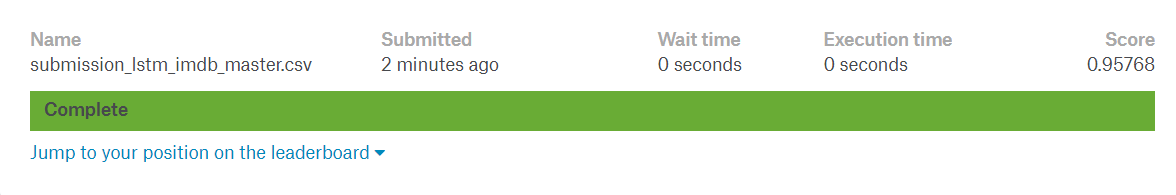

In [70]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from keras.models import load_model
from keras import backend as K#返回当前后端
from keras.models import Sequential,Model
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Embedding,LSTM,Layer,initializers,regularizers,constraints,Input,Dropout,concatenate,BatchNormalization
from keras.layers import Dense,Bidirectional,Concatenate,Multiply,Maximum,Subtract,Lambda,dot,Flatten,Reshape
import gc


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#静态Attention Model
class AttentionLayer(Layer):
    def __init__(self,step_dim,W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)	#正则化
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)		#约束、限制
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias										#偏置
        self.step_dim = step_dim								#step维度
        self.features_dim = 0									#特征维度

        super(AttentionLayer,self).__init__(**kwargs)#用于调用父类(超类)的一个方法。

    #设置self.supports_masking = True后需要复写该方法
    def compute_mask(self, inputs, mask=None):
        return None

    #参数设置，必须实现
    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],),#词向量维度，神经元个数
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]#词向量维度
        if self.bias:
            self.b = self.add_weight((input_shape[1],),#词的个数，神经元个数
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,#正则化
                                     constraint=self.b_constraint)	#约束和限制
        else:
            self.b = None
        self.built = True

    # input (None,sentence_length,embedding_size)
    def call(self, x, mask = None):
        # 计算输出
        features_dim = self.features_dim#词向量维度
        step_dim = self.step_dim		#词的个数

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        # print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim


    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



In [71]:

embed_size = 128

left_input = Input(shape=(130,), dtype='int32')
# 定义需要使用的网络层
embedding_layer1 = Embedding(
    input_dim=6000,
    output_dim=128,
    trainable=True,
    input_length=130
)
att_layer1 = AttentionLayer(130)

#bi_lstm_layer =Bidirectional(LSTM(32, return_sequences = True))
bi_lstm_layer =Bidirectional(LSTM(32))

#bi_lstm_layer = globalMaxp(bi_lstm_layer)

s1 = embedding_layer1(left_input)
s1_bi = bi_lstm_layer(s1)
s1_att = att_layer1(s1)
s1_last = Concatenate(axis=1)([s1_att,s1_bi])#横着拼接
dense_layer1 = Dense(20,activation='relu')(s1_last)
dropout1 = Dropout(0.05)(dense_layer1)
dense_layer2 = Dense(1,activation='sigmoid')(dropout1)

model = Model(inputs=left_input,outputs=[dense_layer2], name="simaese_lstm_attention")

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 130)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 130, 128)     768000      input_3[0][0]                    
__________________________________________________________________________________________________
attention_layer_3 (AttentionLay (None, 128)          258         embedding_4[0][0]                
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 64)           41216       embedding_4[0][0]                
__________________________________________________________________________________________________
concatenat

In [73]:
batch_size = 100
epochs = 3
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 45s 2ms/step - loss: 0.0522 - acc: 0.9840 - val_loss: 0.5606 - val_acc: 0.8504
Epoch 2/3
20000/20000 [==============================] - 45s 2ms/step - loss: 0.0473 - acc: 0.9850 - val_loss: 0.6668 - val_acc: 0.8500
Epoch 3/3
20000/20000 [==============================] - 44s 2ms/step - loss: 0.0272 - acc: 0.9921 - val_loss: 0.7165 - val_acc: 0.8512


In [74]:
df_test=pd.read_csv("data/testData.tsv",header=0, delimiter="\t", quoting=3)
df_test.head()
df_test["review"]=df_test.review.apply(lambda x: clean_text(x))
df_test["sentiment"] = df_test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
y_test = df_test["sentiment"]
list_sentences_test = df_test["review"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

prediction = model.predict(X_te)
y_pred = (prediction > 0.5)

from sklearn.metrics import f1_score, confusion_matrix

print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
confusion_matrix(y_pred, y_test)

F1-score: 0.842258181671442
Confusion matrix:


array([[10655,  2064],
       [ 1845, 10436]], dtype=int64)

In [62]:
import numpy as np

test_predicted = np.array(model.predict(X_te))
test_predicted =list(map(lambda x:1 if x >0.5 else 0 ,test_predicted))

df_test=pd.read_csv("data/testData.tsv",header=0, delimiter="\t", quoting=1)

print('保存结果...')
submission_df = pd.DataFrame(data ={'id': df_test['id'], 'sentiment': test_predicted})
print(submission_df.head(5))
submission_df.to_csv('submission_DSSM_bi-lstm_attention_imdb_master.csv',columns = ['id','sentiment'], index = False)
print('结束.')


保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          0
3    7186_2          0
4   12128_7          1
结束.


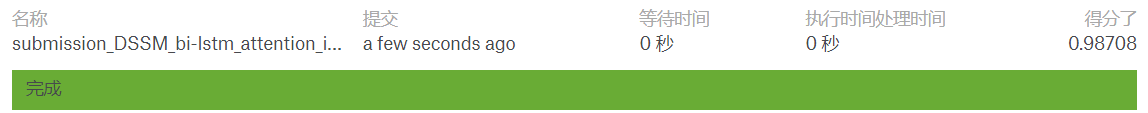

## Top 3 共578组

# MaxPooling1D和GlobalMaxPooling1D的区别

In [23]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, GlobalMaxPooling1D,MaxPooling1D

D = np.random.rand(10, 6, 10)

model = Sequential()
model.add(LSTM(16, input_shape=(6, 10), return_sequences=True))
model.add(MaxPooling1D(pool_size=2, strides=1))
model.add(LSTM(10))
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer='sgd')

# print the summary to see how the dimension change after the layers are 
# applied

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 6, 16)             1728      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 16)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                1080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 2,819
Trainable params: 2,819
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
# try a model with GlobalMaxPooling1D now

model = Sequential()
model.add(LSTM(16, input_shape=(6, 10), return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer='sgd')

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 6, 16)             1728      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 1,745
Trainable params: 1,745
Non-trainable params: 0
_________________________________________________________________
None
